#What is RNN?

- RNN stands for Recurrent Neural Network, which is a type of neural network designed for processing sequential data such as time series or natural language. The key characteristic of RNN is that it has a recurrent connection, which allows the network to use the output from previous time steps as input to the current time step.

#What is LSTM?

- LSTM stands for Long Short-Term Memory, which is a type of RNN that addresses the vanishing gradient problem. The vanishing gradient problem occurs when the gradient of the error with respect to the parameters in the network becomes too small to update the weights, which can prevent the network from learning. LSTMs use a more complex architecture than simple RNNs that includes "memory cells" and "gates" to selectively remember or forget information from previous time steps. This allows LSTMs to better handle long-term dependencies in the input data, which is particularly useful for tasks such as language modeling and speech recognition.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import os

In [ ]:
# Import the Google Colaboratory drive module
from google.colab import drive

# Mount the Google Drive to the Colab notebook
# This code will prompt the user to authenticate and give permission for Colab to access their Google Drive
# After successful authentication, the user's Google Drive will be mounted to the Colab notebook at the specified directory ('/content/drive')
drive.mount('/content/drive')


Mounted at /content/drive


# Dataset

This code defines two lists:

- 'INPUT_SIGNAL_TYPES' is a list of strings that contains the names of the different types of sensor data that were recorded in the experiment. The strings in the list correspond to the different components of the body and total acceleration and gyroscopic data that were recorded by the sensors, such as the x, y, and z axes of the body gyroscope and total acceleration.

- 'LABELS' is a list of strings that contains the names of the different activities that the subjects in the experiment were performing while the sensor data was being recorded. The strings in the list correspond to the different labels that can be used to classify the sensor data according to the activity being performed by the subject. The activity labels include walking, walking upstairs, walking downstairs, sitting, standing, and laying.

In [ ]:
# Define a list of sensor signal types for the input data
# These signal types correspond to the different types of body and total acceleration and gyroscopic data 
# that were recorded by the sensors in the experiment
INPUT_SIGNAL_TYPES = [ "body_gyro_x_", "body_gyro_y_", "body_gyro_z_", "total_acc_x_", "total_acc_y_", "total_acc_z_", "body_acc_x_", "body_acc_y_", "body_acc_z_"]

# Define a list of activity labels for the output data
# These labels correspond to the different activities that the subjects in the experiment were performing 
# while the sensor data was being recorded
LABELS = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"] 


- This code defines a function 'load_input_data' that reads in the input data from a list of file paths and returns it as a NumPy array. The input data is expected to be in a specific format where each file contains a series of rows, each of which corresponds to a single timestep of sensor data, and each row contains a space-separated list of numerical values representing the different sensor signal types. The function uses a list comprehension to read in each row from the file as a NumPy array of float32 values, and then appends these arrays to a list of input data arrays. The final output is a NumPy array of shape (number of samples, number of timesteps, number of input features), where each sample corresponds to a different time series of sensor data, and each timestep corresponds to a single row in the original file. The function assumes that the input data has already been preprocessed and formatted correctly.

In [ ]:
# Import the dataclass_transform module from the typing_extensions library
from typing_extensions import dataclass_transform

# Define constants for the training and test datasets and the path to the dataset directory
TRAIN_PATH = "/train"
TEST_PATH = "/test"
DATASET_PATH = "/content/drive/MyDrive/LSTM-Human-Activity-Recognition-master/UCI HAR Dataset/UCI HAR Dataset"

# Define a function for loading the input data from the dataset
# This function takes a list of file paths as input, reads in the data from each file,
# and returns a NumPy array containing the input data
def load_input_data(file_paths):
    input_data = []
    
    for path in file_paths:
        file = open(path, 'r')
        
        # Append each series of input data to the input_data list as a NumPy array
        input_data.append(
            [np.array(series, dtype=np.float32) for series in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    # Convert the input_data list into a NumPy array with shape (number of samples, number of timesteps, number of input features)
    # by transposing the dimensions of the array
    return np.transpose(np.array(input_data), (1, 2, 0))


- Now we have loaded the input data from the training and test datasets into 'X_train' and 'X_test' NumPy arrays, respectively, using the 'load_input_data()' function.

- We can move on to loading the output labels for the training and test datasets using the 'load_output_data()' function.

In [ ]:
# Define the file paths for the input data in the training and test datasets
train_input_paths = [
    DATASET_PATH + TRAIN_PATH + "/Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
test_input_paths = [
    DATASET_PATH + TEST_PATH + "/Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

# Load the input data from the training and test datasets using the load_input_data function
X_train = load_input_data(train_input_paths)
X_test = load_input_data(test_input_paths)

- This function loads the output data from a given file path, converts it to a NumPy array with data type np.int32, and subtracts 1 from each element in the array to shift the labels to the range [0, num_classes - 1].

In [ ]:
# Define a function for loading the output data from the dataset
# This function takes a file path as input, reads in the data from the file,
# and returns a NumPy array containing the output data
def load_output_data(y_path):
    file = open(y_path, 'r')
    
    # Convert the output data to a NumPy array with data type np.int32
    output_data = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Subtract 1 from each element in the output array to shift the labels to the range [0, num_classes - 1]
    return output_data - 1

- Now we have successfully loaded the input and output data from the training and test datasets. Next, we can proceed with preprocessing the data.

In [ ]:
# Define the file paths for the output data in the training and test datasets
train_output_path = DATASET_PATH + TRAIN_PATH + "/y_train.txt"
test_output_path = DATASET_PATH + TEST_PATH + "/y_test.txt"

# Load the output data from the training and test datasets using the load_output_data function
y_train = load_output_data(train_output_path)
y_test = load_output_data(test_output_path)

# Hyperparameters

These hyperparameters are used to define the architecture and training settings for the LSTM model. Here's a brief explanation of what each hyperparameter does:

- 'training_data_count': the number of training examples in the dataset.
- 'test_data_count': the number of testing examples in the dataset.
- 'n_steps': the number of timesteps in each input sequence.
- 'n_input': the number of input features for each timestep.
- 'n_hidden': the number of hidden units in the LSTM layer.
- 'n_classes': the number of output classes (i.e., activity labels).
- 'learning_rate': the learning rate used by the optimizer during training.
- 'lambda_loss_amount': the L2 regularization coefficient used in the loss function to prevent overfitting.
- 'training_iters': the total number of training iterations to run during training.
- 'batch_size': the number of training examples to include in each batch during training.
- 'display_iter': how frequently to display the training loss during training.

In [ ]:
# Set up hyperparameters
training_data_count = len(X_train) # number of training examples
test_data_count = len(X_test) # number of testing examples
n_steps = len(X_train[0]) # number of timesteps in each sequence
n_input = len(X_train[0][0]) # number of input features
n_hidden = 32 # number of hidden units in the LSTM layer
n_classes = 6 # number of output classes
learning_rate = 0.0025 # learning rate for the optimizer
lambda_loss_amount = 0.0015 # L2 regularization coefficient
training_iters = training_data_count * 300 # number of training iterations
batch_size = 1500 # batch size for each iteration
display_iter = 30000 # frequency of displaying loss during training

In [ ]:
# Print useful information about the dataset
print("Some useful information about the dataset:")
print("Number of training examples:", training_data_count)
print("Number of testing examples:", test_data_count)
print("Number of timesteps in each sequence:", n_steps)
print("Number of input features:", n_input)
print("Number of hidden units in the LSTM layer:", n_hidden)
print("Number of output classes:", n_classes)
print("Learning rate for the optimizer:", learning_rate)
print("L2 regularization coefficient:", lambda_loss_amount)
print("Number of training iterations:", training_iters)
print("Batch size for each iteration:", batch_size)
print("Frequency of displaying loss during training:", display_iter)
print("X shape:", X_test.shape)
print("Y shape:", y_test.shape)
print("Every X's mean:", np.mean(X_test))
print("every X's standard deviation: ", np.std(X_test))
print("As a result, the dataset has been appropriately normalized but has not yet been one-hot encoded.")

Some useful information about the dataset:
Number of training examples: 7352
Number of testing examples: 2947
Number of timesteps in each sequence: 128
Number of input features: 9
Number of hidden units in the LSTM layer: 32
Number of output classes: 6
Learning rate for the optimizer: 0.0025
L2 regularization coefficient: 0.0015
Number of training iterations: 2205600
Batch size for each iteration: 1500
Frequency of displaying loss during training: 30000
X shape: (2947, 128, 9)
Y shape: (2947, 1)
Every X's mean: 0.09913989
every X's standard deviation:  0.39567083
As a result, the dataset has been appropriately normalized but has not yet been one-hot encoded.


# Training

- The LSTM_RNN function takes an input tensor, weights, and biases as inputs and returns the output tensor. The input tensor is transposed to the shape of [n_steps, batch_size, n_input] and then reshaped to the shape of [(n_steps * batch_size), n_input]. The output of the hidden layer is then passed through the ReLU activation function, split into n_steps tensors of shape [batch_size, n_hidden], and applied to two LSTM cells. A MultiRNNCell is created with the defined cells, and the LSTM cells are applied to the input tensor to get the output tensor and final state tensor. The last output tensor is then multiplied by the weights and added to the biases to get the final output tensor.

In [ ]:
import tensorflow as tf
import numpy as np

# Define LSTM_RNN function that takes input tensor, weights, and biases and returns output tensor
def LSTM_RNN(input_tensor, weights, biases, n_input, n_hidden, n_steps):

    # Transpose input tensor to get it in the shape of [n_steps, batch_size, n_input]
    input_tensor = tf.transpose(input_tensor, [1, 0, 2])  

    # Reshape input tensor to get it in the shape of [(n_steps * batch_size), n_input]
    input_tensor = tf.reshape(input_tensor, [-1, n_input]) 

    # Apply ReLU activation to the output of hidden layer
    input_tensor = tf.nn.relu(tf.matmul(input_tensor, weights['hidden']) + biases['hidden'])

    # Split input tensor into n_steps tensors of shape [batch_size, n_hidden]
    input_tensor = tf.split(input_tensor, n_steps, 0) 

    # Define two LSTM cells and create a MultiRNNCell with the defined cells
    lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

    # Apply the LSTM cells to the input tensor to get the output tensor and final state tensor
    outputs, states = tf.compat.v1.nn.static_rnn(lstm_cells, input_tensor, dtype=tf.float32)

    # Get the last output tensor from the outputs tensor
    lstm_last_output = outputs[-1]

    # Multiply the last output tensor with the weights and add biases to get the final output tensor
    return tf.matmul(lstm_last_output, weights['out']) + biases['out']

- This function extracts a batch of size 'batch_size' from the training data at a given step. It takes the training data '_train_data', the current step 'step', the batch size 'batch_size', and the number of steps 'n_steps' as input parameters.

- First, it creates a new empty numpy array of shape '[batch_size, n_steps, n_input]'. Then it loops through each element in the batch and fills it with the corresponding element from the training data. The index is calculated based on the current step, batch size, and length of the training data. The modulo operator '%' is used to wrap around when the index exceeds the length of the training data.

- The function returns the batch as a numpy array.

In [ ]:
# Define function to extract a batch of size batch_size from the training data at a given step
def extract_batch(_train_data, step, batch_size, n_steps):

    # Create a new empty numpy array of shape [batch_size, n_steps, n_input]
    shape = list(_train_data.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    # Loop through each element in the batch and fill it with the corresponding element from the training data
    for i in range(batch_size):
        index = ((step-1)*batch_size + i) % len(_train_data)
        batch_s[i] = _train_data[index] 

    return batch_s

- The 'one_hot_encode' function takes the input 'y_', which is a one-dimensional array of class labels, and the number of output classes 'n_classes'. It first reshapes the input array to have a single dimension using 'reshape'. It then uses 'np.eye(n_classes)' to create an identity matrix of size '(n_classes, n_classes)', which will be used to one-hot encode the input array. Finally, it indexes into the identity matrix using the input array to get the corresponding rows for each input element, which gives the one-hot encoded representation of the input array. The function returns the one-hot encoded array.

In [ ]:
# Define function to convert the class labels to one-hot encoded vectors
def one_hot_encode(y_, n_classes):

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]

# Building the Neural Network

- This is a TensorFlow code that defines a LSTM (Long Short-Term Memory) RNN (Recurrent Neural Network) model for a classification task.

- The code defines a function 'LSTM_RNN' that takes as input a tensor 'input_tensor', the model's 'weights' and 'biases', and other hyperparameters ('n_input', 'n_hidden', 'n_steps') and returns the output tensor. The function applies an LSTM layer to the input tensor and returns the output of the last time step.

- Then, the code defines a function 'extract_batch' that extracts a batch of size 'batch_size' from the training data at a given step.

- A function 'one_hot_encode' is defined to convert the class labels to one-hot encoded vectors.

- The code then defines TensorFlow placeholders for input and output data ('x' and 'y', respectively) and initializes the model's weights and biases.

- Next, it generates predictions using the 'LSTM_RNN' function and defines the cost function using softmax cross-entropy with logits and L2 regularization.

- Finally, it defines an Adam optimizer to minimize the cost function and computes the accuracy of the model using the 'correct_pred' and 'accuracy' tensors.






In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# Define placeholders for input and output data
x = tf.placeholder(tf.float32, [None, n_steps, n_input]) # input tensor with shape [batch_size, n_steps, n_input]
y = tf.placeholder(tf.float32, [None, n_classes]) # output tensor with shape [batch_size, n_classes]

# Define the weights and biases of the model
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Generate predictions using the LSTM_RNN function
pred = LSTM_RNN(x, weights, biases, n_input, n_hidden, n_steps)

# Define the regularization term using L2 loss
l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

# Define the cost function using softmax cross entropy with logits and the L2 regularization term
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2

# Define the optimizer as Adam with the given learning rate and minimize the cost function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Compute the accuracy of the model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


<ipython-input-10-22ca7a28dbc4>:20: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
<ipython-input-10-22ca7a28dbc4>:21: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to f

# Training the Neural Network

- The code is a script for a recurrent neural network (RNN) model using the Long Short-Term Memory (LSTM) architecture. The purpose of the script is to train and evaluate the performance of the model on a classification task.

- The code first defines the necessary hyperparameters for the model, such as the number of hidden units, the number of input features, the number of classes, the learning rate, the lambda loss amount for regularization, and the number of training iterations.

- Then, it defines two functions, 'LSTM_RNN' and 'extract_batch', for creating the RNN model and extracting batches of data, respectively. It also defines a function 'one_hot_encode' for one-hot encoding the class labels.

- Next, it sets up the TensorFlow graph by defining the placeholders for the input and output data, the weights and biases of the model, the cost function, and the optimizer. It also defines the accuracy metric for evaluating the performance of the model.

- After setting up the graph, the code initializes an interactive session and starts the training process. It loops through the training data in batches and runs the optimizer to update the model parameters. It also calculates the training loss and accuracy at each iteration and appends them to their respective lists. Every 'display_iter' iterations, it evaluates the current model on the testing set and calculates the testing loss and accuracy. It also appends them to their respective lists and prints the results. After the training process is finished, it evaluates the final model on the testing set and stores the one-hot encoded predictions in 'one_hot_predictions'. Finally, it appends the final testing loss and accuracy to their respective lists and prints a message indicating that the optimization process is finished.

In [ ]:
# Create empty lists to store the training and testing losses and accuracies
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Create an interactive session and initialize all the global variables
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Set the step counter to 1 and start training the model in a loop until the maximum number of training iterations is reached.
step = 1
while step * batch_size <= training_iters:
    # Extract the current batch of training data and labels and convert the labels to one-hot encoding.
    batch_xs = extract_batch(X_train, step, batch_size, n_steps)
    batch_ys = one_hot_encode(extract_batch(y_train, step, batch_size, n_steps), n_classes)   

    # Run the optimizer and calculate the current training loss and accuracy using the current batch of data.
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )

    # Append the training loss and accuracy to their respective lists.
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Print the training loss and accuracy every display_iter steps or if it's the first iteration or if the training is finished.
    # Then, evaluate the current model on the testing set and calculate the testing loss and accuracy. 
    # Append the testing loss and accuracy to their respective lists.
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot_encode(y_test, n_classes)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    # Increment the step counter after every iteration.
    step += 1

# Print a message to indicate that the optimization process is finished.
print("Optimization process is Finished!")

# Evaluate the final model on the testing set and calculate the final testing loss and accuracy. 
# Store the one-hot encoded predictions in one_hot_predictions.
one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot_encode(y_test, n_classes)
    }
)

# Append the final testing loss and accuracy to their respective lists.
test_losses.append(final_loss)
test_accuracies.append(accuracy)

Device mapping: no known devices.
Training iter #1500:   Batch Loss = 2.864554, Accuracy = 0.12866666913032532
PERFORMANCE ON TEST SET: Batch Loss = 2.437720775604248, Accuracy = 0.328130304813385
Training iter #30000:   Batch Loss = 1.441445, Accuracy = 0.612666666507721
PERFORMANCE ON TEST SET: Batch Loss = 1.5441793203353882, Accuracy = 0.591109573841095
Training iter #60000:   Batch Loss = 1.275233, Accuracy = 0.6940000057220459
PERFORMANCE ON TEST SET: Batch Loss = 1.3471741676330566, Accuracy = 0.6779776215553284
Training iter #90000:   Batch Loss = 1.144946, Accuracy = 0.7753333449363708
PERFORMANCE ON TEST SET: Batch Loss = 1.2697298526763916, Accuracy = 0.7478792071342468
Training iter #120000:   Batch Loss = 1.041317, Accuracy = 0.8473333120346069
PERFORMANCE ON TEST SET: Batch Loss = 1.1675081253051758, Accuracy = 0.8069223165512085
Training iter #150000:   Batch Loss = 0.889277, Accuracy = 0.8899999856948853
PERFORMANCE ON TEST SET: Batch Loss = 1.1582340002059937, Accuracy

In [ ]:
# Print the final testing loss and accuracy.
print("Final Result: " +
    "Batch Loss = {}".format(final_loss) +
    ", Accuracy = {}".format(accuracy))


Final Result: Batch Loss = 0.4998471736907959, Accuracy = 0.8985409140586853


# Results

- This code generates a plot of the training and testing losses and accuracies over the course of the training process. The x-axis represents the number of training iterations, while the y-axis represents the values of the losses and accuracies.

- The training loss and accuracy are plotted as dashed blue and green lines, respectively. The testing loss and accuracy are plotted as solid blue and green lines, respectively.

- The plot is titled "Training session's progress over iterations" and has a legend in the upper right corner indicating which line represents which metric. The y-axis is labeled "Training Progress (Loss or Accuracy values)" and the x-axis is labeled "Training iteration". The font for the plot is set to "DejaVu Sans", and the size and weight of the font are set to 18 and bold, respectively. The width and height of the figure are set to 12.

- The plot is displayed using Matplotlib's show() function.

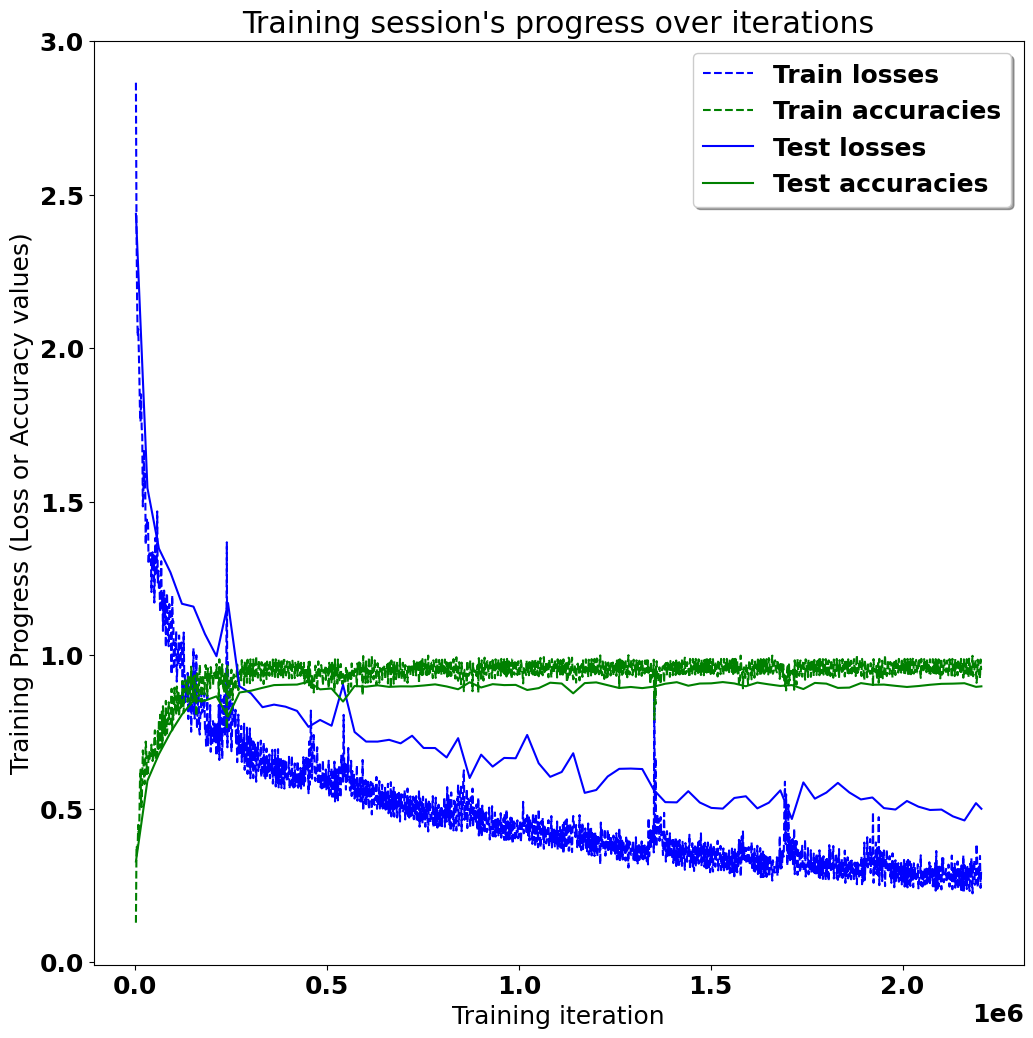

In [ ]:
# Set the font family and size for the plot
import matplotlib
import matplotlib.font_manager as font_manager
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Show the plot in the Jupyter notebook
%matplotlib inline

# Define the font for the plot
font = {
    'family' : 'DejaVu Sans',
    'weight' : 'bold',
    'size' : 18
}
matplotlib.rc('font', **font)

# Set the width and height of the figure
width = 12
height = 12

# Create a new plot
plt.figure(figsize=(width, height))

# Define the x-axis for the training plot
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))

# Plot the training loss and accuracy
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

# Define the x-axis for the testing plot
indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)

# Plot the testing loss and accuracy
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

# Set the title and labels for the plot
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

# Show the plot
plt.show()


# Multi-Class Confusion Matrix & Metrics

- The testing accuracy achieved by the model is 89.85%. The precision, recall, and f1_score for the model are 90.32%, 89.85%, and 89.84%, respectively.

- The confusion matrix shows the number of correctly and incorrectly classified examples for each class. The rows represent the true classes, while the columns represent the predicted classes. The normalized confusion matrix shows the same information but normalized to the total number of test data points.

- The confusion matrix shows that the model performs well for classes 1, 2, and 3, while it struggles with classes 4 and 5. This could be due to the imbalanced distribution of data between the classes. The normalized confusion matrix confirms this, as classes 1, 2, and 3 have a relatively higher percentage of correctly classified examples compared to classes 4 and 5. The model has a high accuracy for class 6, but it should be noted that this class has a disproportionately higher number of test examples compared to the other classes.

In [ ]:
# Set the font family for the plot
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Make predictions using the trained model
predictions = one_hot_predictions.argmax(1)

# Print out the testing accuracy and other evaluation metrics
print("Testing Accuracy: {}%".format(100*accuracy))
print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

# Print out the confusion matrix and the normalised confusion matrix
print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
print("")
print("Matrix of confusion (normalized to % of the total test data):")
print(normalised_confusion_matrix)
print("Note that not all classes receive an equal distribution of training and testing data, ")
print("Therefore, it is expected that more than a sixth of the data is classified correctly in the final category.")

Testing Accuracy: 89.85409140586853%

Precision: 90.32894877331198%
Recall: 89.85408890397014%
f1_score: 89.84558429279365%

Confusion Matrix:
[[465   0  31   0   0   0]
 [ 22 401  46   0   0   2]
 [  2   0 418   0   0   0]
 [  0   1   0 419  71   0]
 [  1   2   0 121 408   0]
 [  0   0   0   0   0 537]]

Matrix of confusion (normalized to % of the total test data):
[[15.778758    0.          1.0519172   0.          0.          0.        ]
 [ 0.7465219  13.607058    1.5609094   0.          0.          0.06786563]
 [ 0.06786563  0.         14.183916    0.          0.          0.        ]
 [ 0.          0.03393281  0.         14.217849    2.4092298   0.        ]
 [ 0.03393281  0.06786563  0.          4.1058702  13.844588    0.        ]
 [ 0.          0.          0.          0.          0.         18.22192   ]]
Note that not all classes receive an equal distribution of training and testing data, 
Therefore, it is expected that more than a sixth of the data is classified correctly in the f

The code below is plotting the normalized confusion matrix using matplotlib. The size of the plot is defined by the variables 'width' and 'height', and the plot title is "Matrix of confusion (normalized to% of all test data)". The color of the plot is defined by the 'cmap' parameter and set to "hot". The tick marks on the x and y axis represent the class labels defined in the 'LABELS' list, and the 'rotation' parameter is used to rotate the x tick labels by 90 degrees. Finally, the plot is displayed using the 'plt.show()' function

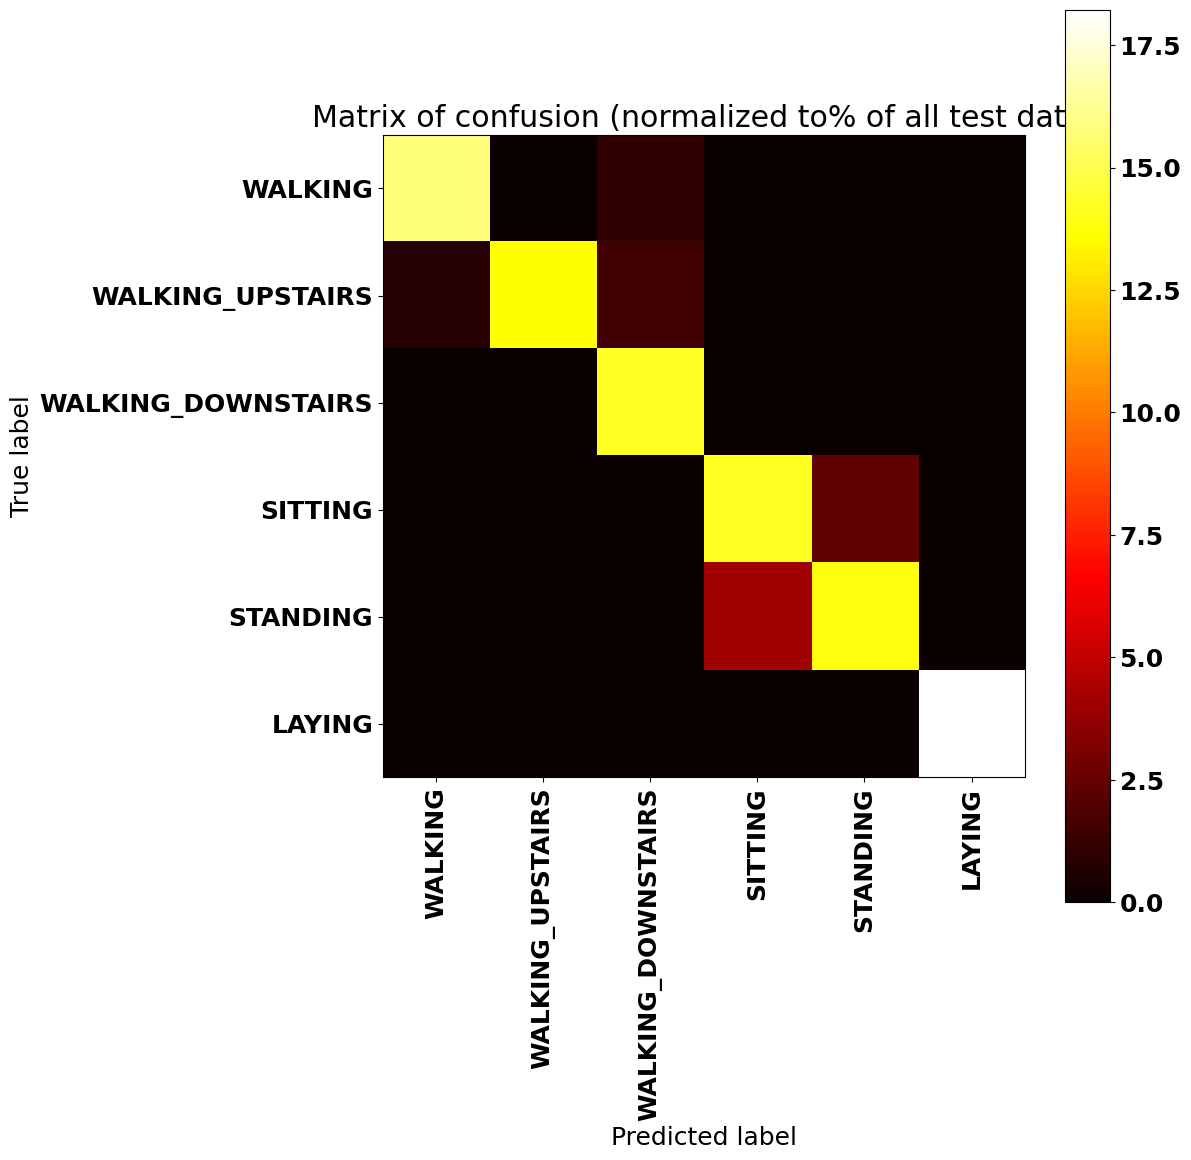

In [ ]:
# Set the width and height of the figure
width = 12
height = 12

# Create a new plot and show the normalised confusion matrix
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.hot
)
plt.title("Matrix of confusion (normalized to% of all test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
